In [1]:
from __future__ import absolute_import
from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, PReLU
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
def UNET_left(X, channel, kernel_size=3, stack_num=2, activation='ReLU', 
              pool=True, batch_norm=False, name='left0'):
    pool_size = 2
    X = encode_layer(X, channel, pool_size, pool, activation=activation, 
                     batch_norm=batch_norm, name='{}_encode'.format(name))
    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv'.format(name))
    return X


def UNET_right(X, X_list, channel, kernel_size=3, 
               stack_num=2, activation='ReLU',
               unpool=True, batch_norm=False, concat=True, name='right0'):
    pool_size = 2
    X = decode_layer(X, channel, pool_size, unpool, 
                     activation=activation, batch_norm=batch_norm, name='{}_decode'.format(name))
    X = CONV_stack(X, channel, kernel_size, stack_num=1, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv_before_concat'.format(name))
    if concat:
        X = concatenate([X,]+X_list, axis=3, name=name+'_concat')
    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name=name+'_conv_after_concat')
    
    return X

def unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2, 
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    activation_func = eval(activation)
    X_skip = []
    depth_ = len(filter_num)
    if backbone is None:
        X = input_tensor
        X = CONV_stack(X, filter_num[0], stack_num=stack_num_down, activation=activation, 
                       batch_norm=batch_norm, name='{}_down0'.format(name))
        X_skip.append(X)
        for i, f in enumerate(filter_num[1:]):
            X = UNET_left(X, f, stack_num=stack_num_down, activation=activation, pool=pool, 
                          batch_norm=batch_norm, name='{}_down{}'.format(name, i+1))        
            X_skip.append(X)
    else:
        if 'VGG' in backbone:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_, freeze_backbone, freeze_batch_norm)
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip)
        else:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_-1, freeze_backbone, freeze_batch_norm)
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip) + 1
        if depth_encode < depth_:
            X = X_skip[-1]
            for i in range(depth_-depth_encode):
                i_real = i + depth_encode
                X = UNET_left(X, filter_num[i_real], stack_num=stack_num_down, activation=activation, pool=pool, 
                              batch_norm=batch_norm, name='{}_down{}'.format(name, i_real+1))
                X_skip.append(X)
    X_skip = X_skip[::-1]
    X = X_skip[0]
    X_decode = X_skip[1:]
    depth_decode = len(X_decode)
    filter_num_decode = filter_num[:-1][::-1]
    for i in range(depth_decode):
        X = UNET_right(X, [X_decode[i],], filter_num_decode[i], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, name='{}_up{}'.format(name, i))
    if depth_decode < depth_-1:
        for i in range(depth_-depth_decode-1):
            i_real = i + depth_decode
            X = UNET_right(X, None, filter_num_decode[i_real], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, concat=False, name='{}_up{}'.format(name, i_real))   
    return X

def unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    activation_func = eval(activation)
    if backbone is not None:
        bach_norm_checker(backbone, batch_norm)
    IN = Input(input_size) 
    X = unet_2d_base(IN, filter_num, stack_num_down=stack_num_down, stack_num_up=stack_num_up, 
                     activation=activation, batch_norm=batch_norm, pool=pool, unpool=unpool, 
                     backbone=backbone, weights=weights, freeze_backbone=freeze_backbone, 
                     freeze_batch_norm=freeze_backbone, name=name)
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    return model

In [3]:
# === Data simulada ===
AUS_IMG_DIR = "archive/abdominal_US/AUS/images/train"
AUS_MASK_DIR = "archive/abdominal_US/AUS/annotations/train"
sim_files = sorted([f for f in os.listdir(AUS_IMG_DIR) if f.endswith(".png")])  # 633 pares

# === Data real ===
RUS_IMG_DIR = "archive/abdominal_US/RUS/images/test"
RUS_MASK_DIR = "archive/abdominal_US/RUS/annotations/test"
real_base_files = sorted([
    f for f in os.listdir(RUS_MASK_DIR)
    if f.endswith(".png") and os.path.exists(os.path.join(RUS_IMG_DIR, f.replace(".png", ".jpg")))
])
real_files = [f.replace(".png", ".jpg") for f in real_base_files]  # 60 archivos con imagen + máscara

# === División real en 80/20
from sklearn.model_selection import train_test_split
real_train_files, real_val_files = train_test_split(real_files, test_size=0.2, random_state=42)  # 48 y 12


In [4]:
joint_train_files = sim_files + real_train_files

class MixedUltrasoundDataset(Sequence):
    def __init__(self, sim_files, real_files, sim_img_dir, sim_mask_dir, real_img_dir, real_mask_dir,
                 batch_size=2, img_size=(128,128), n_classes=9):
        self.sim_files = sim_files
        self.real_files = real_files
        self.all_files = sim_files + real_files
        self.sim_img_dir = sim_img_dir
        self.sim_mask_dir = sim_mask_dir
        self.real_img_dir = real_img_dir
        self.real_mask_dir = real_mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.all_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.all_files[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            if fname in self.sim_files:
                img_path = os.path.join(self.sim_img_dir, fname)
                mask_path = os.path.join(self.sim_mask_dir, fname)
            else:
                img_path = os.path.join(self.real_img_dir, fname)
                mask_path = os.path.join(self.real_mask_dir, fname.replace(".jpg", ".png"))

            # Carga imagen y máscara
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path)
            if img is None or mask is None:
                continue

            img = cv2.resize(img, self.img_size).astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)


In [5]:
class UltrasoundDataset(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=2, img_size=(128,128), n_classes=9):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            # Imagen
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            # Máscara
            mask = cv2.imread(os.path.join(self.mask_dir, fname.replace(".jpg", ".png")))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)

In [6]:
# Imagen reescalada (más liviana para tu RTX 3050)
IMG_SIZE = (128, 128)

# Número de clases incluyendo fondo
N_CLASSES = 9

# Tamaños por nivel (U-Net reducida)
FILTER_NUM = [32, 64, 128, 256]

# Batch size bajo por límite de VRAM
BATCH_SIZE = 2

color_to_class = {
    (0, 0, 0): 0,         # fondo
    (100, 0, 100): 1,     # hígado (violeta oscuro)
    (255, 255, 0): 2,     # riñón (amarillo)
    (0, 0, 255): 3,       # páncreas (azul)
    (255, 0, 0): 4,       # vasos (rojo)
    (0, 255, 255): 5,     # suprarrenales (celeste)
    (0, 255, 0): 6,       # vesícula (verde)
    (255, 255, 255): 7,   # huesos (blanco)
    (255, 0, 255): 8      # bazo (rosado)
}

def rgb_mask_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)

    for color, class_id in color_to_class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_id

    return mask_class

In [7]:
train_gen = MixedUltrasoundDataset(
    sim_files=sim_files,
    real_files=real_train_files,
    sim_img_dir=AUS_IMG_DIR,
    sim_mask_dir=AUS_MASK_DIR,
    real_img_dir=RUS_IMG_DIR,
    real_mask_dir=RUS_MASK_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_classes=N_CLASSES
)

val_gen = UltrasoundDataset(
    real_val_files,
    img_dir=RUS_IMG_DIR,
    mask_dir=RUS_MASK_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_classes=N_CLASSES
)

In [8]:
model = unet_2d(
    input_size=(IMG_SIZE[0], IMG_SIZE[1], 1),
    filter_num=FILTER_NUM,
    n_labels=N_CLASSES,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    output_activation='Softmax',
    batch_norm=True,
    pool=True,
    unpool=True,
    backbone=None
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint("retrain_joint_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50
341/341 [==============================] - 24s 41ms/step - loss: 0.6813 - accuracy: 0.8112 - val_loss: 1.3499 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 2/50
341/341 [==============================] - 10s 30ms/step - loss: 0.4269 - accuracy: 0.8580 - val_loss: 1.4801 - val_accuracy: 0.1891 - lr: 0.0010
Epoch 3/50
341/341 [==============================] - 11s 31ms/step - loss: 0.3864 - accuracy: 0.8703 - val_loss: 1.2559 - val_accuracy: 0.5633 - lr: 0.0010
Epoch 4/50
341/341 [==============================] - 10s 30ms/step - loss: 0.3596 - accuracy: 0.8792 - val_loss: 1.9308 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 5/50
341/341 [==============================] - 10s 30ms/step - loss: 0.3380 - accuracy: 0.8872 - val_loss: 1.3344 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 6/50
341/341 [==============================] - 10s 30ms/step - loss: 0.3164 - accuracy: 0.8946 - val_loss: 1.3226 - val_accuracy: 0.5558 - lr: 0.0010
Epoch 7/50
341/341 [==============================] - 10s 

In [10]:
def mask_class_to_rgb(mask_class):
    h, w = mask_class.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_to_color.items():
        rgb_mask[mask_class == class_id] = color
    return rgb_mask
class_to_color = {
    0: (0, 0, 0),           # fondo
    1: (100, 0, 100),       # hígado (violeta oscuro)
    2: (255, 255, 0),       # riñón (amarillo)
    3: (0, 0, 255),         # páncreas (azul)
    4: (255, 0, 0),         # vasos (rojo)
    5: (0, 255, 255),       # suprarrenales (celeste)
    6: (0, 255, 0),         # vesícula (verde)
    7: (255, 255, 255),     # huesos (blanco)
    8: (255, 0, 255),       # bazo (rosado)
}

1/1 [==============================] - 0s 17ms/step


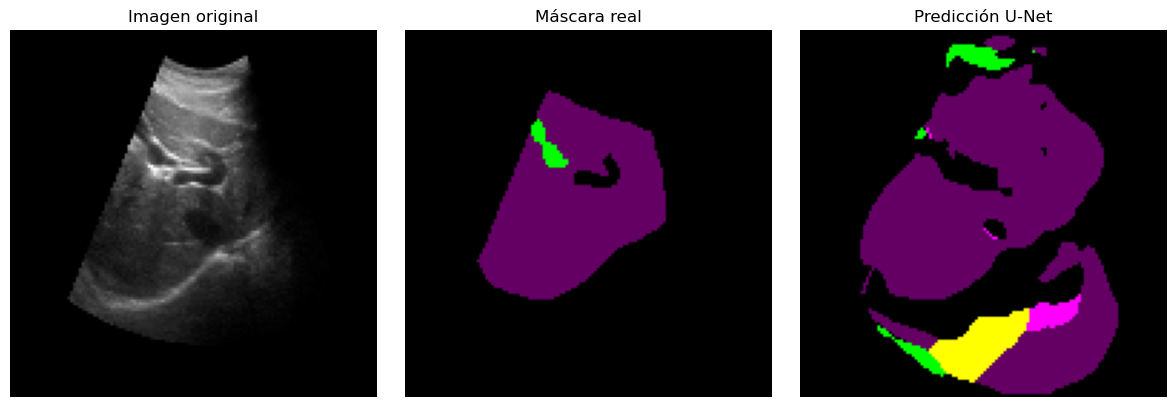

In [22]:
# === CONFIGURACIÓN ===
IMG_SIZE = (128, 128)
filename = "archive/abdominal_US/RUS/images/test/a9.jpg"  # ← Cambia aquí el path completo

# === Definir rutas base
AUS_IMG_DIR = "archive/abdominal_US/AUS/images/train"
AUS_MASK_DIR = "archive/abdominal_US/AUS/annotations/train"
RUS_IMG_DIR = "archive/abdominal_US/RUS/images/test"
RUS_MASK_DIR = "archive/abdominal_US/RUS/annotations/test"

# === Detectar origen
fname = os.path.basename(filename)

if fname.endswith(".png"):
    img_path = os.path.join(AUS_IMG_DIR, fname)
    mask_path = os.path.join(AUS_MASK_DIR, fname)
elif fname.endswith(".jpg"):
    img_path = os.path.join(RUS_IMG_DIR, fname)
    mask_path = os.path.join(RUS_MASK_DIR, fname.replace(".jpg", ".png"))
else:
    raise ValueError("Solo se permiten archivos .png (AUS) o .jpg (RUS)")

# === Validar existencia
if not os.path.exists(img_path):
    raise FileNotFoundError(f"No existe imagen: {img_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"No existe máscara: {mask_path}")

# === Cargar imagen
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# === Cargar máscara real
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class = rgb_mask_to_class(mask)
mask_rgb_gt = mask_class_to_rgb(mask_class)

# === Predicción del modelo
pred = model.predict(img_input)[0]
pred_class = np.argmax(pred, axis=-1)
pred_rgb = mask_class_to_rgb(pred_class)

# === Visualización
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen original")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_rgb_gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción U-Net")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()